In [124]:
# @title code functions
import ee
import os
import io
import json
import geemap
import pandas as pd
import urllib.request

import seaborn

def json_to_pandas(data, columns):
  #json_io = io.StringIO(data)
  #df = pd.read_json(json_io)
  #df = pd.read_json(data)
  df = pd.DataFrame(data)
  print("df.shape:", df.shape )

  first_row = df.iloc[0]
  #print("first_row:", first_row)

  df = df[columns]
  print("columns:", print(df.columns))
  return df


def json_load_from_url(url):
  #url = "https://raw.githubusercontent.com/test-earth-engine/gee1/main/Jsons/ucdp_v241_y2020.json";
  output_file = "output.json"
  urllib.request.urlretrieve(url, output_file)
  print(f"File saved to: {output_file}")

  response = urllib.request.urlopen(url)
  data = response.read().decode()
  json_data = json.loads(data)
  #print(json_data)
  return json_data


def authentification_drive() :
  from google.colab import drive
  drive.mount('/content/drive')


def authentification_ee() :
  ## https://developers.google.com/earth-engine/guides/python_install
  service_account = "undp-test-earth-engine@undp-test-earth-engine.iam.gserviceaccount.com"
  try :
    credentials = ee.ServiceAccountCredentials(service_account, 'undp-test-earth-engine.json')
    ee.Initialize(credentials)
  except :
    ee.Authenticate()
    ee.Initialize(project="undp-test-earth-engine")

  print("[earth_tools]", ee.String('Earth Engine...').getInfo())


In [156]:
# @title code functions
def plot_geometry(geometry):
    m = geemap.Map(center=[0, 0], zoom=2)
    m.addLayer(geometry, {}, 'Merged Circle')
    m.addLayerControl()
    return m

def plot_geometries(geometries):
    m = geemap.Map(center=[0, 0], zoom=2)
    for k,v in geometries.items():
      m.addLayer(k, {}, v)
    m.addLayerControl()
    return m

def total_population_get(dataset, region_of_interest) :
  clipped_dataset = dataset.unmask(0).clip(region_of_interest)

  projection = dataset.projection(); #print(projection.nominalScale())

  total_population = clipped_dataset.reduceRegion(
      scale=projection.nominalScale(),
      reducer=ee.Reducer.sum(),
      geometry=region_of_interest,
      maxPixels=1e9
  )

  population_value = total_population.get('population_count')
  return population_value.getInfo(), clipped_dataset


def population_calculate(collection, region_of_interest):
  #collection = ee.ImageCollection('CIESIN/GPWv411/GPW_Population_Count')
  available_dates = collection.aggregate_array('system:time_start').map(lambda t: ee.Date(t).format('YYYY-MM-dd'))

  population = {}
  json_data = []
  for start_date in available_dates.getInfo() :
    subcollection = collection.filterDate(start_date, None)
    population_value, clipped_dataset = total_population_get(subcollection.first(), region_of_interest)
    #print(start_date, population_value )
    population[start_date] = population_value,clipped_dataset
    json_data.append({'start_date':start_date, 'population_value':population_value})

  return json_data


def total_population_test() :
  collection = ee.ImageCollection('CIESIN/GPWv411/GPW_Population_Count')
  collection_info = collection.getInfo()

  country_name = "Mexico"
  countries = ee.FeatureCollection("FAO/GAUL/2015/level0")
  country = countries.filter(ee.Filter.eq('ADM0_NAME', country_name))

  json_data = population_calculate(collection, country)
  print(json_data)
  assert(json_data[-1]["population_value"] == 140028589.62193522)

  lat,lon = 19.4326, -99.1332  # Mexico city
  region_of_interest = ee.Geometry.Point([lon,lat]).buffer(50000)
  json_data = population_calculate(collection, region_of_interest)
  print(json_data)
  assert(json_data[0]["population_value"] == 18894142.261089187)

#total_population_test()

In [6]:
# @title authentifications
authentification_ee()
authentification_drive()

[earth_tools] Earth Engine...
Mounted at /content/drive


In [106]:
# @title total_population_test
%%time
total_population_test()

[{'start_date': '2000-01-01', 'population_value': 95318311.04757665}, {'start_date': '2005-01-01', 'population_value': 102920410.05733086}, {'start_date': '2010-01-01', 'population_value': 111962007.6113942}, {'start_date': '2015-01-01', 'population_value': 123252080.51942815}, {'start_date': '2020-01-01', 'population_value': 140028589.62193522}]
[{'start_date': '2000-01-01', 'population_value': 18894142.261089187}, {'start_date': '2005-01-01', 'population_value': 19634927.00906701}, {'start_date': '2010-01-01', 'population_value': 20565562.540432516}, {'start_date': '2015-01-01', 'population_value': 21753302.396740124}, {'start_date': '2020-01-01', 'population_value': 23301046.330478065}]
CPU times: user 118 ms, sys: 12.3 ms, total: 130 ms
Wall time: 18.7 s


In [25]:
# @title ucdp_v241_y2020
url = "https://raw.githubusercontent.com/test-earth-engine/gee1/main/Jsons/ucdp_v241_y2020.json";
data = json_load_from_url(url)

columns = ["latitude", "longitude", "date_start", "best", "id", "country"]
df = json_to_pandas(data, columns)
#print( df )

File saved to: output.json
df.shape: (13384, 49)
Index(['latitude', 'longitude', 'date_start', 'best', 'id', 'country'], dtype='object')
columns: None


In [52]:
grouped = df.groupby('country')

In [53]:
import matplotlib.pyplot as plt

def plot_best_by_country( data ):
    data = data.sort_values(ascending=False)
    data.plot(kind='bar')
    plt.yscale('log')
    plt.show()

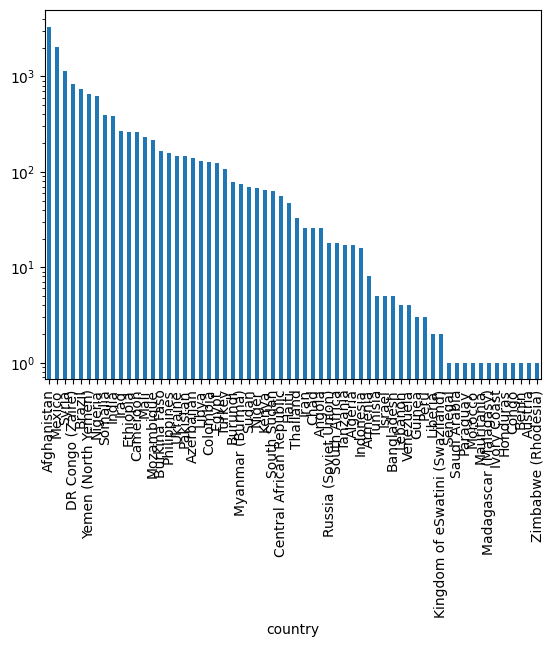

In [54]:
sizes = grouped.size()
plot_best_by_country( sizes )

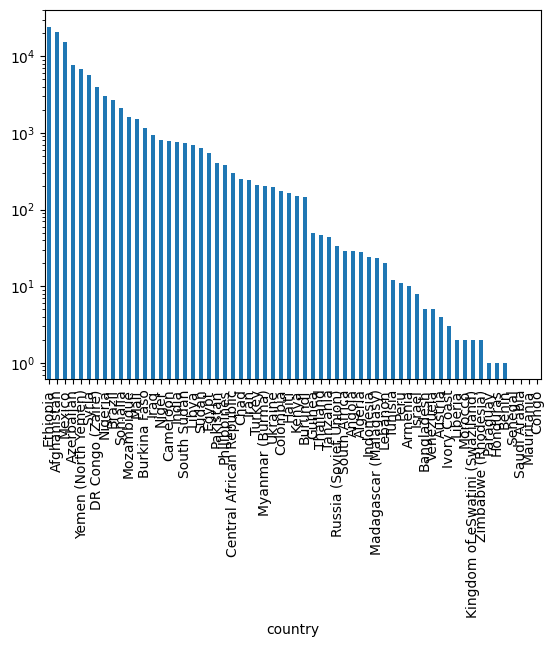

In [56]:
bests = grouped['best'].sum()
plot_best_by_country( bests )

[get_unique_coords_by_country] country:'Ukraine' coords: 55
List of keys: 55
type: MultiPolygon
CPU times: user 153 ms, sys: 17.4 ms, total: 171 ms
Wall time: 2.55 s


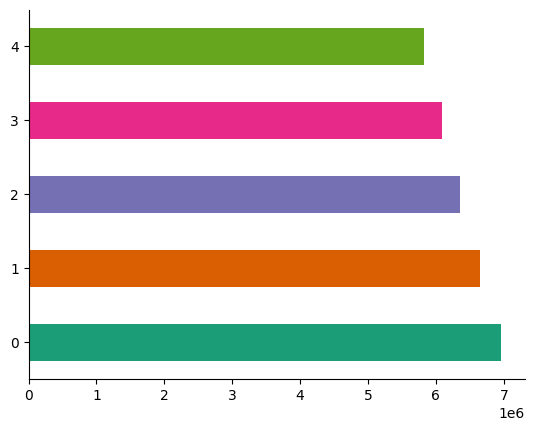

In [134]:
# @title Ukraine Test Population
%%time

def population_total_calculate(collection, region_of_interest) :
  #collection = ee.ImageCollection('CIESIN/GPWv411/GPW_Population_Count')
  json_data = population_calculate(collection, region_of_interest)
  #print(json_data)
  return json_data


def create_merged_circle(coords, radius=50000): # 50 km
    circles = ee.FeatureCollection([
        ee.Feature(ee.Geometry.Point(coord).buffer(radius)) for coord in coords
    ])
    merge_geometries = lambda feature, merged : ee.Geometry(merged).union(feature.geometry())
    return ee.Geometry(circles.iterate(merge_geometries, ee.Geometry(circles.first().geometry())))


def get_unique_coords_by_country(key):
  group1 = grouped.get_group(key)
  #print( group1.iloc[0] )

  group_of_coords = group1.groupby(['longitude', 'latitude'])
  print(f"[get_unique_coords_by_country] country:'{key}'", "coords:", len(group_of_coords) )

  #for name2, group2 in group_of_coords:print(key, name2 , len(group2) )

  unique_coords = list(group_of_coords.groups.keys())
  print(f"List of keys: {len(unique_coords)}")
  return unique_coords


def population_total_by_country(collection, country) :
  coordinates = get_unique_coords_by_country(country)
  #assert( len(coordinates) == 55 )

  radius = 50 * 1000 # km -> m
  merged_circle_geometry = create_merged_circle(coordinates, radius)
  print("type:", merged_circle_geometry.getInfo()["type"]) # 'MultiPolygon'
  #assert( merged_circle_geometry.getInfo()["type"] == 'MultiPolygon' )

  json_data = population_total_calculate(collection, merged_circle_geometry)
  #assert(json_data[0]["population_value"] == 6958498.409845306) ## 'start_date': '2000-01-01'

  df = pd.DataFrame(json_data)
  return df, merged_circle_geometry


country = "Ukraine"
collection = ee.ImageCollection('CIESIN/GPWv411/GPW_Population_Count')

populations,region_of_interest = population_total_by_country(collection, country)
populations['population_value'].plot(kind='barh', color=seaborn.palettes.mpl_palette('Dark2'))
#plt.xscale('log')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [129]:
plot_geometry(region_of_interest)

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [138]:
%%time
countries = list(grouped.groups.keys())
print(f"countries({len(countries)}): {countries}")

regions = {}
populations = {}
for i,country in enumerate(countries[:]):
  population,region = population_total_by_country(collection, country)
  regions[country] = region
  populations[country] = population
  print(i, country, population)


countries(62): ['Afghanistan', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bangladesh', 'Benin', 'Brazil', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Colombia', 'Congo', 'DR Congo (Zaire)', 'Egypt', 'Ethiopia', 'Guinea', 'Haiti', 'Honduras', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Ivory Coast', 'Kenya', 'Kingdom of eSwatini (Swaziland)', 'Lebanon', 'Liberia', 'Libya', 'Madagascar (Malagasy)', 'Mali', 'Mauritania', 'Mexico', 'Morocco', 'Mozambique', 'Myanmar (Burma)', 'Niger', 'Nigeria', 'Pakistan', 'Paraguay', 'Peru', 'Philippines', 'Russia (Soviet Union)', 'Saudi Arabia', 'Senegal', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Syria', 'Tanzania', 'Thailand', 'Tunisia', 'Turkey', 'Ukraine', 'Venezuela', 'Yemen (North Yemen)', 'Zimbabwe (Rhodesia)']
[get_unique_coords_by_country] country:'Afghanistan' coords: 1159
List of keys: 1159
type: Polygon
0 Afghanistan    start_date  population_value
0  2000-01-01      2.636630e+07
1

In [282]:
messages = []
for key,values in populations.items():
  values = values.to_dict(orient='records')
  print(key)
  print(values)


In [266]:
populations_values = {}
for key,values in populations.items():
  populations_values[key] = values['population_value'][0] / 1e6

populations_values = pd.DataFrame(list(populations_values.items()), columns=['Country', 'Value'])

min_value = populations_values['Value'].min()
populations_values['Value'] = populations_values['Value'] - min_value

max_value = populations_values['Value'].max()
populations_values['Value'] = populations_values['Value'] / max_value

min_value = populations_values['Value'].min()
max_value = populations_values['Value'].max()

populations_values = populations_values.set_index('Country')['Value'].to_dict()
print(populations_values)

{'Afghanistan': 0.1639322533910146, 'Algeria': 0.03100015486201785, 'Angola': 0.01528743497031637, 'Armenia': 0.015145310230671028, 'Austria': 0.015181744534155411, 'Azerbaijan': 0.02689655975143522, 'Bangladesh': 0.17113963822727846, 'Benin': 0.001208809149674718, 'Brazil': 0.3665263584417549, 'Burkina Faso': 0.04557801577740762, 'Burundi': 0.06471991549307939, 'Cameroon': 0.0641132483124731, 'Central African Republic': 0.014178494574419217, 'Chad': 0.0038193961575951614, 'Colombia': 0.12489770031459224, 'Congo': 0.0065469091504362, 'DR Congo (Zaire)': 0.17118373571116344, 'Egypt': 0.12978136009806668, 'Ethiopia': 0.19797139922382437, 'Guinea': 0.005235904484087051, 'Haiti': 0.02083469261276774, 'Honduras': 0.007611240486566161, 'India': 1.0, 'Indonesia': 0.0021227431596284444, 'Iran': 0.1332423897398424, 'Iraq': 0.12401628834235809, 'Israel': 0.05490335984213241, 'Ivory Coast': 0.0037547694986613204, 'Kenya': 0.11063618384707709, 'Kingdom of eSwatini (Swaziland)': 0.00472511114362541

In [233]:
messages = []
for key,values in populations.items():
  message = f"{key} : "
  values = values.to_dict(orient='records')
  #values = [f"{v['start_date']}:{v['population_value']/1e6:.2f}" for v in values[:1]]
  #message += "|".join(values)
  message += f"{values[0]['population_value'] / 1e6:.2f}"
  messages.append(message)

print( messages )

['Afghanistan : 26.37', 'Algeria : 4.99', 'Angola : 2.46', 'Armenia : 2.44', 'Austria : 2.44', 'Azerbaijan : 4.33', 'Bangladesh : 27.53', 'Benin : 0.19', 'Brazil : 58.95', 'Burkina Faso : 7.33', 'Burundi : 10.41', 'Cameroon : 10.31', 'Central African Republic : 2.28', 'Chad : 0.61', 'Colombia : 20.09', 'Congo : 1.05', 'DR Congo (Zaire) : 27.53', 'Egypt : 20.87', 'Ethiopia : 31.84', 'Guinea : 0.84', 'Haiti : 3.35', 'Honduras : 1.22', 'India : 160.84', 'Indonesia : 0.34', 'Iran : 21.43', 'Iraq : 19.95', 'Israel : 8.83', 'Ivory Coast : 0.60', 'Kenya : 17.79', 'Kingdom of eSwatini (Swaziland) : 0.76', 'Lebanon : 3.55', 'Liberia : 1.31', 'Libya : 2.46', 'Madagascar (Malagasy) : 0.32', 'Mali : 4.48', 'Mauritania : 0.23', 'Mexico : 83.09', 'Morocco : 0.00', 'Mozambique : 1.30', 'Myanmar (Burma) : 6.47', 'Niger : 3.07', 'Nigeria : 72.16', 'Pakistan : 57.17', 'Paraguay : 0.13', 'Peru : 0.30', 'Philippines : 65.36', 'Russia (Soviet Union) : 8.69', 'Saudi Arabia : 0.80', 'Senegal : 0.40', 'Somali

In [244]:
# @title widgets
import ipywidgets
import ipyleaflet
import ipywidgets as widgets

def message_create(map, message, position) :
  text = f"""
  <div style="
      font-size:14px;
      color:white;
      background-color:black;
      padding: 5px;
      border-radius: 5px;
      opacity: 0.8;
  ">
  {message}
  </div>
  """
  text_widget = ipywidgets.HTML(value=text)
  text_control = ipyleaflet.WidgetControl(widget=text_widget, position=position)
  map.add_control(text_control)


def list_create(map, items, position):
    message = "Show / Hide Population list"

    # Toggle button (styled as plain text)
    toggle_button = ipywidgets.Button(
        description=message,
        layout=ipywidgets.Layout(width='auto'), #, background_color='black'),
        style=dict(button_color='white', font_color='black')
    )


    list_widget = widgets.HTML(
        value=f"<ul>{''.join(f'<li>{item}</li>' for item in items)}</ul>",
        layout=widgets.Layout(height='100px', overflow_y='auto', padding='5px', display='none')
    )

    # Toggle function
    def toggle_list(_):
        list_widget.layout.display = 'block' if list_widget.layout.display == 'none' else 'none'

    # Attach toggle event to button
    toggle_button.on_click(toggle_list)

    # Add widgets to map
    container = widgets.VBox([toggle_button, list_widget])
    map.add_control(ipyleaflet.WidgetControl(widget=container, position=position))


def test() :
  items =  ["Item %d" % i for i in range(100)]
  #items = messages
  map = geemap.Map(center=(20, 0), zoom=2)
  list_create(map, items, 'bottomleft')
  message_create(map, "By SpicyTech", 'topleft')
  return map

test()

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [282]:
%%time
import geemap
import folium
import matplotlib.pyplot as plt

def plot_geometries(geometries, colors) :
    m = geemap.Map(center=[0, 0], zoom=2)

    for name,geometry in geometries.items():
      #m.addLayer(geometry, {}, name)
      color = colors.get(name, 0)
      m.addLayer(geometry, {'color': str(color)}, name)
    #m.addLayerControl()
    return m

def map_plot(regions, values) :
  map = plot_geometries(regions, values)
  list_create(map, messages, 'bottomleft')
  message_create(map, "By SpicyTech", 'topleft')
  map.save("map.html")
  return map

import itertools
print("n_regions:", len(regions) )
sub_regions = dict( itertools.islice(regions.items(),0,None,1) )
print( sub_regions.keys() )

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])

colors = {}
for s in sub_regions.keys() :
  value = populations_values[s]
  color = plt.cm.RdYlBu(value)[:3]  # Get RGB color
  color = [int(c * 255) for c in color]  # Convert to 0-255 scale
  #print(s, value, color)
  colors[s] = rgb_to_hex(color)

map_plot(sub_regions, colors)

n_regions: 62
dict_keys(['Afghanistan', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bangladesh', 'Benin', 'Brazil', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Colombia', 'Congo', 'DR Congo (Zaire)', 'Egypt', 'Ethiopia', 'Guinea', 'Haiti', 'Honduras', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Ivory Coast', 'Kenya', 'Kingdom of eSwatini (Swaziland)', 'Lebanon', 'Liberia', 'Libya', 'Madagascar (Malagasy)', 'Mali', 'Mauritania', 'Mexico', 'Morocco', 'Mozambique', 'Myanmar (Burma)', 'Niger', 'Nigeria', 'Pakistan', 'Paraguay', 'Peru', 'Philippines', 'Russia (Soviet Union)', 'Saudi Arabia', 'Senegal', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Syria', 'Tanzania', 'Thailand', 'Tunisia', 'Turkey', 'Ukraine', 'Venezuela', 'Yemen (North Yemen)', 'Zimbabwe (Rhodesia)'])
CPU times: user 1min 2s, sys: 2.79 s, total: 1min 5s
Wall time: 2min 32s


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [297]:
json_data = []
for key,values in populations.items():
  values = values.to_dict(orient='records')
  for value in values:
    value["country"] = key
    value["ucdp_year"] = 2020
    json_data.append( value )
print(json_data)

file_path = 'ucdp_v241_y2020_gpw_population.json'
with open(file_path, 'w') as json_file:
    json.dump(json_data, json_file, indent=4)

[{'start_date': '2000-01-01', 'population_value': 26366300.903961167, 'country': 'Afghanistan', 'ucdp_year': 2020}, {'start_date': '2005-01-01', 'population_value': 28950109.06453464, 'country': 'Afghanistan', 'ucdp_year': 2020}, {'start_date': '2010-01-01', 'population_value': 31984663.797627393, 'country': 'Afghanistan', 'ucdp_year': 2020}, {'start_date': '2015-01-01', 'population_value': 35524931.17071788, 'country': 'Afghanistan', 'ucdp_year': 2020}, {'start_date': '2020-01-01', 'population_value': 39638138.538149714, 'country': 'Afghanistan', 'ucdp_year': 2020}, {'start_date': '2000-01-01', 'population_value': 4986110.143347442, 'country': 'Algeria', 'ucdp_year': 2020}, {'start_date': '2005-01-01', 'population_value': 5308791.936064149, 'country': 'Algeria', 'ucdp_year': 2020}, {'start_date': '2010-01-01', 'population_value': 5678474.241867955, 'country': 'Algeria', 'ucdp_year': 2020}, {'start_date': '2015-01-01', 'population_value': 6107710.894165489, 'country': 'Algeria', 'ucdp_

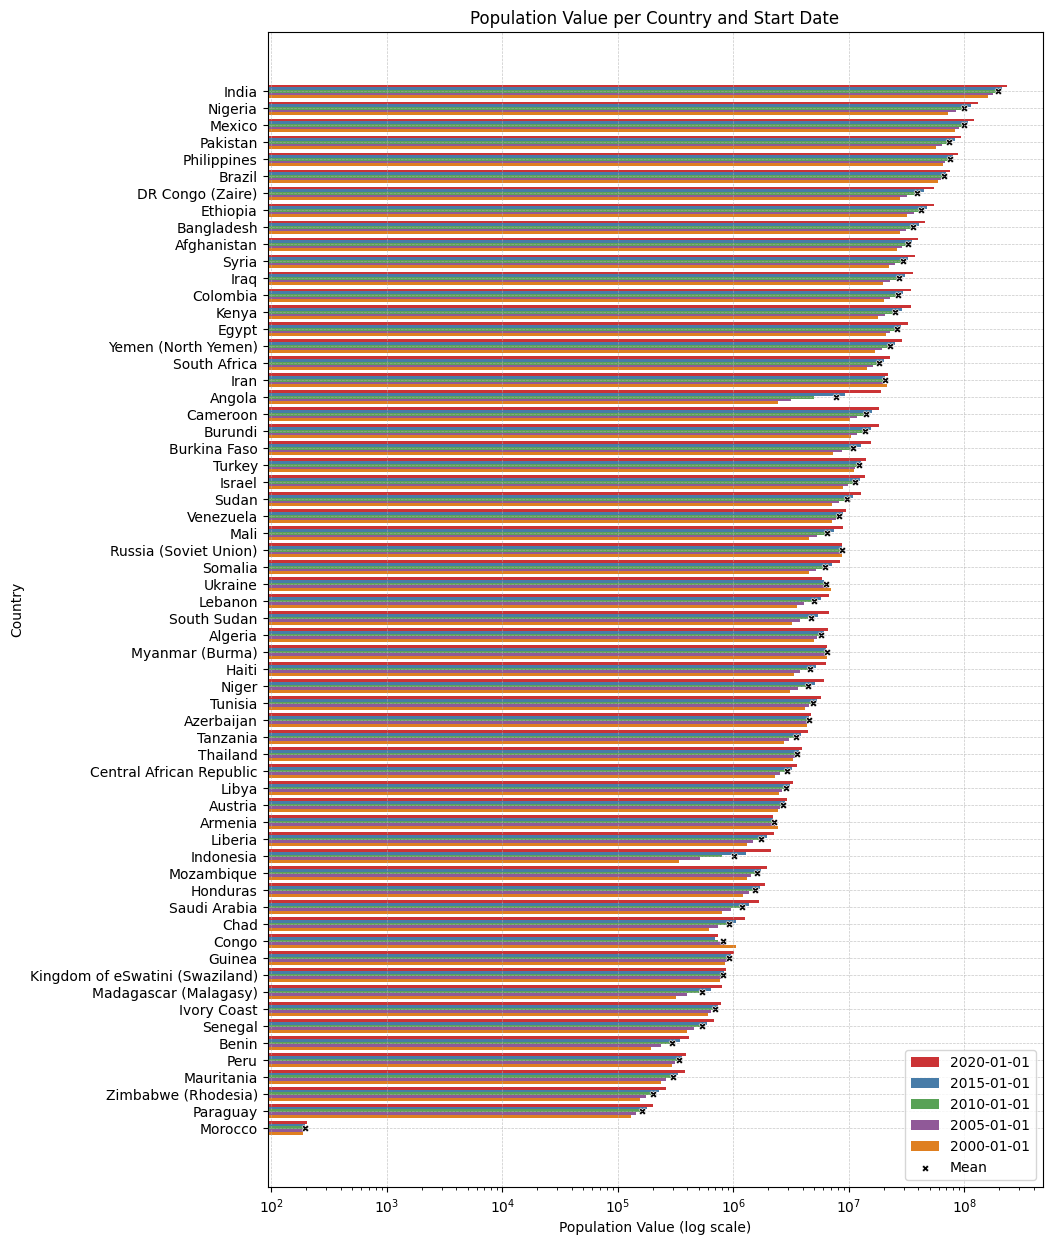

In [324]:
json_data = pd.DataFrame(json_data)
json_data.sort_values(by='population_value', ascending=False, inplace=True)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 15))
sns.barplot(data=json_data, x='population_value', y='country', hue='start_date', palette='Set1')

country_mean = json_data.groupby('country')['population_value'].mean().reset_index()
sns.scatterplot(data=country_mean, x='population_value', y='country', color='black', marker='X', s=25, label='Mean')

plt.xscale('log')
plt.xlabel('Population Value (log scale)')
plt.ylabel('Country')
plt.title('Population Value per Country and Start Date')

plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.savefig('ucdp_v241_y2020_gpw_population.png', bbox_inches='tight')
plt.show()
